In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
import optuna

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import sys
sys.path.append('../src')
from EvaluationFunction import evaluate_model
from PreprocessingFunction import build_preprocessor
from ValidationCross import cross_val_results


from collections import Counter

import joblib

RANDOM_STATE = 42

---
Load DataSet
---

In [2]:
# Load preprocessed data
df_cleaned = pd.read_csv("../data/preprocessed_data.csv")

In [3]:
# Split features and target variable
X = df_cleaned.drop('Exited', axis=1)
y = df_cleaned['Exited']

---
Preprocessing
---

In [4]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y,random_state=42)

In [5]:
preprocessor = build_preprocessor(X_train)
ratio = Counter(y_train)[0] / Counter(y_train)[1]

---
Optuna
---

[I 2026-01-25 14:15:49,112] A new study created in memory with name: no-name-c1f1fe94-6a7d-49bd-b9ec-3b1c450a11c6


[I 2026-01-25 14:16:02,983] Trial 0 finished with value: 0.7010962517797713 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.14423742061977327, 'subsample': 0.8026230688181106}. Best is trial 0 with value: 0.7010962517797713.
[I 2026-01-25 14:16:08,709] Trial 1 finished with value: 0.8206567028589898 and parameters: {'n_estimators': 451, 'max_depth': 3, 'learning_rate': 0.11600027628049928, 'subsample': 0.7591919891175329}. Best is trial 1 with value: 0.8206567028589898.
[I 2026-01-25 14:16:13,295] Trial 2 finished with value: 0.7023418733239576 and parameters: {'n_estimators': 576, 'max_depth': 7, 'learning_rate': 0.15041991697496965, 'subsample': 0.8564081024438558}. Best is trial 1 with value: 0.8206567028589898.
[I 2026-01-25 14:16:22,329] Trial 3 finished with value: 0.6973305614032023 and parameters: {'n_estimators': 651, 'max_depth': 10, 'learning_rate': 0.11801032935552602, 'subsample': 0.7057835443844261}. Best is trial 1 with value: 0.8206567028589898.


--- ÉVALUATION OPTUNA ---
Accuracy: 0.8943333333333333
Precision: 0.8021505376344086
Recall: 0.6237458193979933
F1-score: 0.7017873941674506
AUC: 0.9337334551196188

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2402
           1       0.80      0.62      0.70       598

    accuracy                           0.89      3000
   macro avg       0.86      0.79      0.82      3000
weighted avg       0.89      0.89      0.89      3000



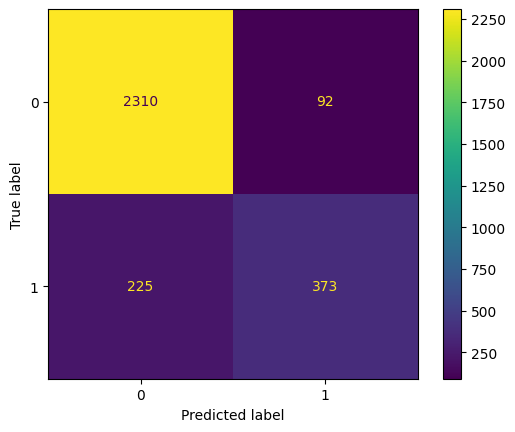

In [6]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "scale_pos_weight": ratio,
        "eval_metric": "logloss",
        "random_state": 42
    }
    model = XGBClassifier(**params)
    pipe = Pipeline([("preprocessor", preprocessor), ("classifier", model)])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(pipe, X_train, y_train, scoring="recall", cv=cv, n_jobs=-1).mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_opt_xgb = XGBClassifier(**study.best_params, random_state=42)
optuna_pipe = Pipeline([("preprocessor", preprocessor), ("classifier", best_opt_xgb)])
optuna_pipe.fit(X_train, y_train)

print("\n--- ÉVALUATION OPTUNA ---")
evaluate_model(y_test, optuna_pipe.predict(X_test), optuna_pipe.predict_proba(X_test)[:, 1])


---
GridSearchCV
---


--- ÉVALUATION GRIDSEARCH ---
Accuracy: 0.893
Precision: 0.784394250513347
Recall: 0.6387959866220736
F1-score: 0.7041474654377881
AUC: 0.9331918217538898

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      2402
           1       0.78      0.64      0.70       598

    accuracy                           0.89      3000
   macro avg       0.85      0.80      0.82      3000
weighted avg       0.89      0.89      0.89      3000



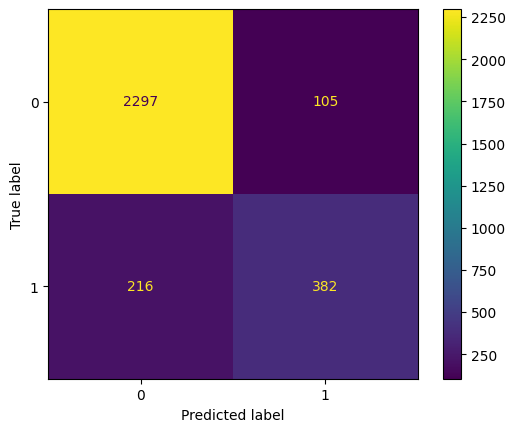

In [7]:
param_grid = {
    "classifier__n_estimators": [study.best_params["n_estimators"] - 50, study.best_params["n_estimators"] + 50],
    "classifier__max_depth": [study.best_params["max_depth"] - 1, study.best_params["max_depth"] + 1]
}

grid = GridSearchCV(optuna_pipe, param_grid, scoring="recall", cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("\n--- ÉVALUATION GRIDSEARCH ---")
evaluate_model(y_test, grid.predict(X_test), grid.predict_proba(X_test)[:, 1])

In [8]:
print("=== Cross Validation: Grid xgbBoost ===")
cross_val_results(grid, X_train, y_train)
print("=== Cross Validation: Optuna xgbBoost ===")
cross_val_results(optuna_pipe, X_train, y_train)

=== Cross Validation: Grid xgbBoost ===
----- Cross Validation Scores -----
accuracy: 0.9010 ± 0.0030
precision: 0.7911 ± 0.0092
recall: 0.6839 ± 0.0080
f1: 0.7336 ± 0.0079
roc_auc: 0.9358 ± 0.0042


=== Cross Validation: Optuna xgbBoost ===
----- Cross Validation Scores -----
accuracy: 0.9012 ± 0.0017
precision: 0.8005 ± 0.0060
recall: 0.6722 ± 0.0089
f1: 0.7307 ± 0.0055
roc_auc: 0.9365 ± 0.0036




---
Class Churn Imbalance 
---


>>> ANALYSE : Sans Équilibre
Recall Score: 0.6388
Accuracy: 0.893
Precision: 0.784394250513347
Recall: 0.6387959866220736
F1-score: 0.7041474654377881
AUC: 0.9331918217538898

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      2402
           1       0.78      0.64      0.70       598

    accuracy                           0.89      3000
   macro avg       0.85      0.80      0.82      3000
weighted avg       0.89      0.89      0.89      3000



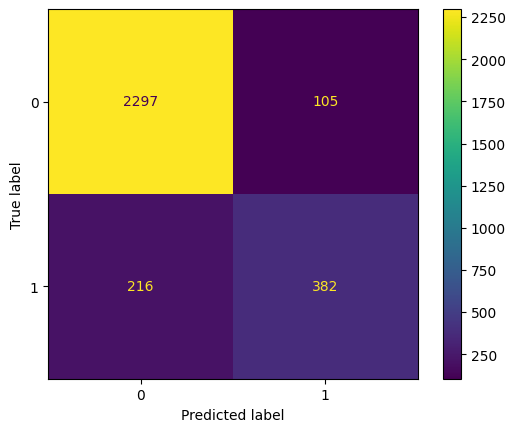


>>> ANALYSE : Weight Only
Recall Score: 0.8328
Accuracy: 0.867
Precision: 0.6248431618569636
Recall: 0.8327759197324415
F1-score: 0.7139784946236559
AUC: 0.9332572633173581

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      2402
           1       0.62      0.83      0.71       598

    accuracy                           0.87      3000
   macro avg       0.79      0.85      0.81      3000
weighted avg       0.89      0.87      0.87      3000



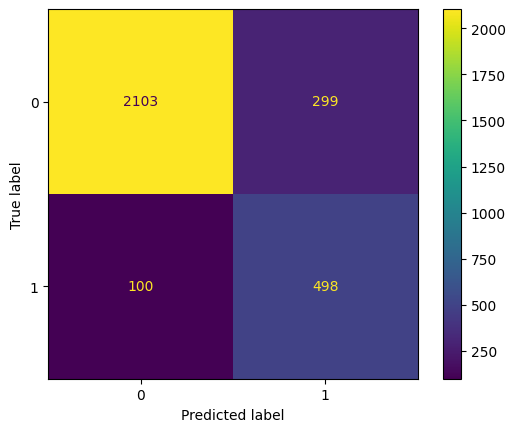

c:\Users\CYTech Student\anaconda3\envs\mon_env\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\CYTech Student\anaconda3\envs\mon_env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")



>>> ANALYSE : SMOTE Only
Recall Score: 0.7726
Accuracy: 0.8856666666666667
Precision: 0.6905829596412556
Recall: 0.7725752508361204
F1-score: 0.7292817679558011
AUC: 0.9314952144116246

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2402
           1       0.69      0.77      0.73       598

    accuracy                           0.89      3000
   macro avg       0.82      0.84      0.83      3000
weighted avg       0.89      0.89      0.89      3000



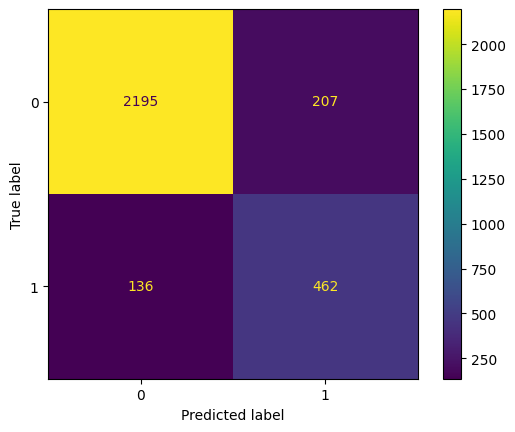


>>> ANALYSE : SMOTE + Weight
Recall Score: 0.8980
Accuracy: 0.8173333333333334
Precision: 0.5244140625
Recall: 0.8979933110367893
F1-score: 0.6621454993834772
AUC: 0.9308964937245717

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.80      0.87      2402
           1       0.52      0.90      0.66       598

    accuracy                           0.82      3000
   macro avg       0.75      0.85      0.77      3000
weighted avg       0.88      0.82      0.83      3000



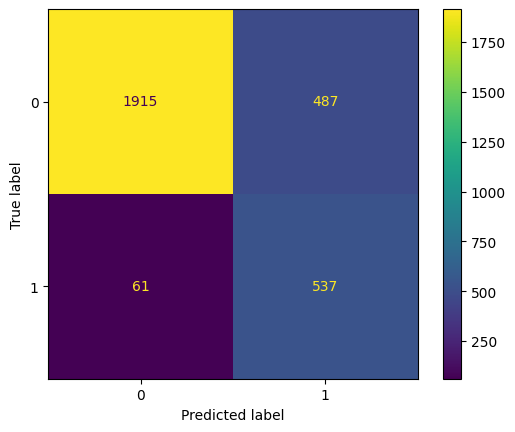

In [9]:
recall_opt = recall_score(y_test, optuna_pipe.predict(X_test))
recall_gs = recall_score(y_test, grid.predict(X_test))

best_params_moteur = grid.best_estimator_.named_steps['classifier'].get_params() if recall_gs >= recall_opt else best_opt_xgb.get_params()
best_params_moteur = {k: v for k, v in best_params_moteur.items() if k not in ['scale_pos_weight']}

strategies = {
    "Sans Équilibre": Pipeline([("preprocessor", preprocessor), ("classifier", XGBClassifier(**best_params_moteur, scale_pos_weight=1))]),
    "Weight Only": Pipeline([("preprocessor", preprocessor), ("classifier", XGBClassifier(**best_params_moteur, scale_pos_weight=ratio))]),
    "SMOTE Only": ImbPipeline([("preprocessor", preprocessor), ("smote", SMOTE(random_state=42)), ("classifier", XGBClassifier(**best_params_moteur, scale_pos_weight=1))]),
    "SMOTE + Weight": ImbPipeline([("preprocessor", preprocessor), ("smote", SMOTE(random_state=42)), ("classifier", XGBClassifier(**best_params_moteur, scale_pos_weight=ratio))])
}

# Évaluation finale basée sur le Recall
final_recall = {}
for name, pipe in strategies.items():
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    y_pred = pipe.predict(X_test)
    
    # Stockage du recall
    final_recall[name] = recall_score(y_test, y_pred)
    
    print(f"\n>>> ANALYSE : {name}")
    print(f"Recall Score: {final_recall[name]:.4f}")
    evaluate_model(y_test, y_pred, y_prob)

---
Selection the best model
---

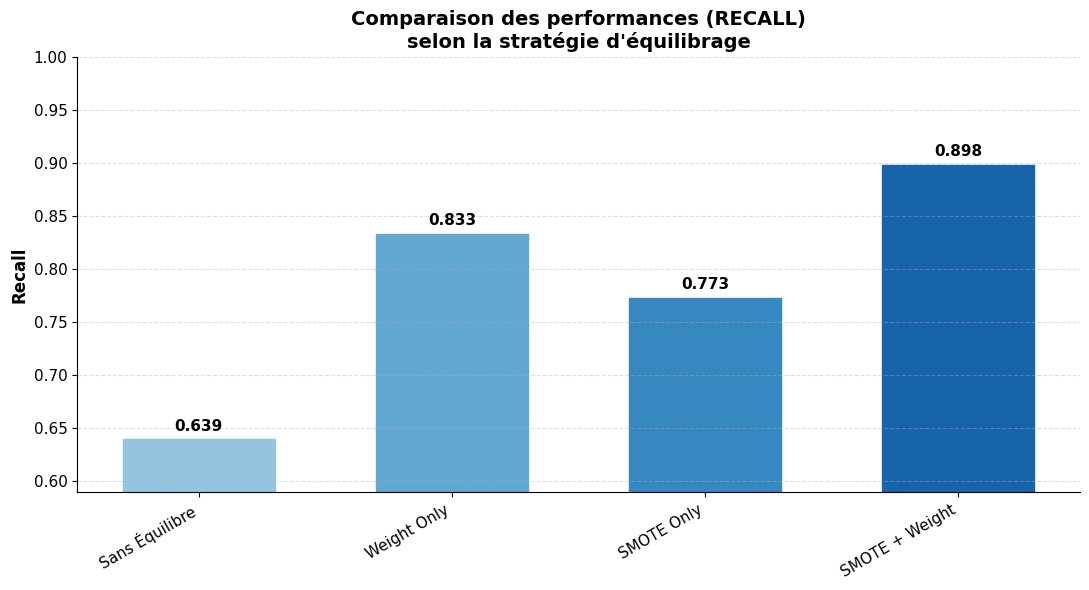

In [10]:
# --- DATA ---
labels = list(final_recall.keys())
values = list(final_recall.values())

# --- FIGURE ---
plt.figure(figsize=(11, 6))

bars = plt.bar(
    labels,
    values,
    width=0.6,
    edgecolor='black',
    linewidth=1
)

# --- COULEURS ---
colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

# --- ANNOTATIONS
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.005,
        f"{height:.3f}",
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold'
    )

# --- AXES & TITRES ---
plt.ylim(min(values) - 0.05, 1.0)
plt.ylabel("Recall", fontsize=12, fontweight='bold')
plt.title(
    "Comparaison des performances (RECALL)\nselon la stratégie d'équilibrage",
    fontsize=14,
    fontweight='bold'
)
# --- STYLE PRO ---
plt.xticks(rotation=30, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Suppression des bordures inutiles
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

In [11]:
best_key = max(final_recall, key=final_recall.get)
joblib.dump(strategies[best_key], '../models/best_model.pkl')

['../models/best_model.pkl']

In [ ]:
# Charger le modèle et faire des prédictions
best_model = joblib.load('../models/best_model.pkl')

# Faire des prédictions sur l'ensemble de test
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Afficher les résultats
print("Prédictions sur les 10 premiers échantillons:")
print(f"Prédictions (0/1): {y_pred[:10]}")
print(f"Probabilités de churn: {y_pred_proba[:10, 1]}")
print(f"\nAccuracy sur l'ensemble de test: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

Prédictions sur les 10 premiers échantillons:
Prédictions (0/1): [1 0 0 0 0 0 1 0 1 0]
Probabilités de churn: [0.8225664  0.2173323  0.03286222 0.08689032 0.07017851 0.17702325
 0.94108105 0.29956073 0.763051   0.07483654]

Accuracy sur l'ensemble de test: 0.8173
Precision: 0.5244
Recall: 0.8980
F1-Score: 0.6621
